In [1]:
#default_exp feature

# Feature Generation

<br>

### Imports

In [2]:
#exports
import numpy as np
import pandas as pd

from evtdemand import data

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data_dir = '../data'

df_features, df_target = data.construct_baseline_features_target_dfs(data_dir)

In [5]:
# need to think about what's needed to forecast demand and solar
# should accept the baseline features df and pass back a new df to be joined (rather than directly adding)

<br>

### Temporal Features

In [6]:
#exports
def dt_rng_to_SPs(
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
    freq: str='30T',
    tz: str='Europe/London'
):
    dt_rng = pd.date_range(start_date, end_date, freq=freq, tz=tz)

    SPs = list((2*(dt_rng.hour + dt_rng.minute/60) + 1).astype(int))
    dt_strs = list(dt_rng.strftime('%Y-%m-%d'))

    df_dates_SPs = pd.DataFrame({'date':dt_strs, 'SP':SPs}, index=dt_rng).astype(str)

    # Accounting for clock changes
    clock_change_dt_idxs_dir = pd.Series(dt_rng).apply(lambda dt: dt.utcoffset().total_seconds()).diff().replace(0, np.nan).dropna()

    for dt_idx, dir_ in clock_change_dt_idxs_dir.items():
        dt = dt_rng[dt_idx].date()
        SPs = (1 + 2*(dt_rng[dt_rng.date==dt] - pd.to_datetime(dt).tz_localize('Europe/London')).total_seconds()/(60*60)).astype(int)

        df_dates_SPs.loc[df_dates_SPs.index.date==dt, 'SP'] = SPs

    return df_dates_SPs

def create_temporal_features(df_features: pd.DataFrame):
    df_dates_SPs = dt_rng_to_SPs(
        df_features.index.min().strftime('%Y-%m-%d %H:%M'),
        df_features.index.max().strftime('%Y-%m-%d %H:%M')
    )
    
    df_dates_SPs.index = df_dates_SPs.index.tz_convert('UTC')
    
    df_temporal = pd.DataFrame({
        # 'SP': df_dates_SPs['SP'].values,
        'hour': df_features.index.hour + df_features.index.minute/60,
        'local_hour': df_features.index.tz_convert('Europe/London').hour + df_features.index.tz_convert('Europe/London').minute/60,
        'doy': df_features.index.dayofyear,
        'weekend': df_features.index.dayofweek.isin([5, 6])
    }, index=df_features.index)
    
    return df_temporal

In [7]:
df_temporal = create_temporal_features(df_features)

df_temporal.head()

,hour,local_hour,doy,weekend
time,,,,
2019-11-01 00:00:00+00:00,0.0,0.0,305,False
2019-11-01 00:30:00+00:00,0.5,0.5,305,False
2019-11-01 01:00:00+00:00,1.0,1.0,305,False
2019-11-01 01:30:00+00:00,1.5,1.5,305,False
2019-11-01 02:00:00+00:00,2.0,2.0,305,False


<br>

### Wind Vectors to Speed and Direction

In [8]:
#exports
def create_dir_speed_features(s_U: pd.Series, s_V: pd.Series):
    df_speed_dir = pd.DataFrame({
        'direction': np.mod(180 + np.rad2deg(np.arctan2(s_U, s_V)), 360),
        'speed': np.sqrt(s_U**2 + s_V**2)
    })

    return df_speed_dir

<AxesSubplot:xlabel='speed', ylabel='Count'>

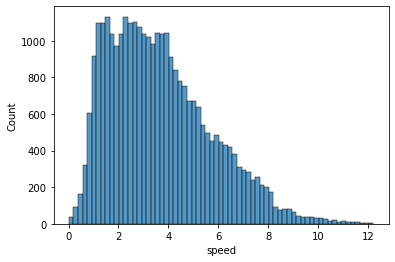

In [9]:
df_speed_dir = create_dir_speed_features(df_features['windspeed_east'], df_features['windspeed_north'])

sns.histplot(df_speed_dir['speed'])

<br>

### Heating/Cooling Degree Hour

In [10]:
#exports
def calc_hcdh_factor(
    t: float,
    hbt: float=10,
    cbt: float=20, 
    beta_0: float=0, 
    beta_1: float=1, 
    beta_2: float=2
):
    if isinstance(t, pd.Series):
        hdh = (hbt-t).to_frame().assign(ref=0).max(axis=1)
        cdh = (t-cbt).to_frame().assign(ref=0).max(axis=1)
        
    else:
        hdh = max(0, hbt-t)
        cdh = max(0, t-cbt)
    
    hcdh_factor = beta_0 + beta_1*hdh + beta_2*cdh
    
    return hcdh_factor

def create_hcdh_features(df_features: pd.DataFrame):
    df_hcdh_factor = calc_hcdh_factor(df_features['temperature']).to_frame()
    df_hcdh_factor = df_hcdh_factor.rename(columns={0: 'hcdh'})
    
    return df_hcdh_factor

<AxesSubplot:xlabel='time'>

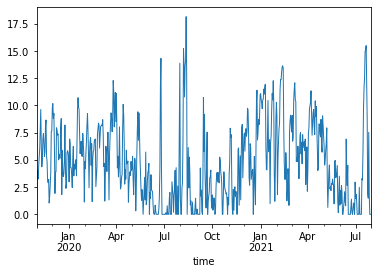

In [11]:
df_hcdh_factor = create_hcdh_features(df_features)

df_hcdh_factor['hcdh'].resample('d').max().plot(linewidth=1)

In [12]:
#exports
def create_prev_month_stats_df(df_features: pd.DataFrame, df_target: pd.DataFrame):
    s_avg_to_max = df_target['value_max'] - df_features['value']
    s_avg_to_min = df_target['value_min'] - df_features['value']

    df_prev_month_stats = pd.DataFrame({
        'prev_month_max_avg': s_avg_to_max.resample('MS').mean().shift().reindex(s_avg_to_max.index).ffill().dropna(),
        'prev_month_max_max': s_avg_to_max.resample('MS').max().shift().reindex(s_avg_to_max.index).ffill().dropna(),
        'prev_month_min_avg': s_avg_to_min.resample('MS').mean().shift().reindex(s_avg_to_min.index).ffill().dropna(),
        'prev_month_min_min': s_avg_to_min.resample('MS').min().shift().reindex(s_avg_to_min.index).ffill().dropna()
    })
    
    return df_prev_month_stats

In [13]:
df_prev_month_stats = create_prev_month_stats_df(df_features, df_target)

df_prev_month_stats.head()

,prev_month_max_avg,prev_month_max_max,prev_month_min_avg,prev_month_min_min
time,,,,
2019-12-01 00:00:00+00:00,0.10239,1.101552,-0.106499,-1.39748
2019-12-01 00:30:00+00:00,0.10239,1.101552,-0.106499,-1.39748
2019-12-01 01:00:00+00:00,0.10239,1.101552,-0.106499,-1.39748
2019-12-01 01:30:00+00:00,0.10239,1.101552,-0.106499,-1.39748
2019-12-01 02:00:00+00:00,0.10239,1.101552,-0.106499,-1.39748


In [14]:
#exports
def create_lagged_df(df_features: pd.DataFrame):
    df_lagged = pd.DataFrame({
        'value_lagged_1': df_features['value'].shift().bfill()
    })
    
    return df_lagged

In [15]:
create_lagged_df(df_features).head()

,value_lagged_1
time,
2019-11-01 00:00:00+00:00,1.101302
2019-11-01 00:30:00+00:00,1.101302
2019-11-01 01:00:00+00:00,1.084653
2019-11-01 01:30:00+00:00,0.998729
2019-11-01 02:00:00+00:00,0.914548


In [16]:
#exports
def create_additional_features(
    df_features: pd.DataFrame, 
    df_target: pd.DataFrame=None,
    features: list=['temporal', 'dir_speed', 'hcdh', 'prev_month_stats', 'lagged']
):
    if 'temporal' in features:
        df_features = df_features.merge(create_temporal_features(df_features), left_index=True, right_index=True)
    
    if 'dir_speed' in features:
        df_features = df_features.merge(create_dir_speed_features(df_features['windspeed_east'], df_features['windspeed_north']), left_index=True, right_index=True)
    
    if 'hcdh' in features:
        df_features = df_features.merge(create_hcdh_features(df_features), left_index=True, right_index=True)
    
    if 'prev_month_stats' in features:
        assert df_target is not None
        df_features = df_features.merge(create_prev_month_stats_df(df_features, df_target), left_index=True, right_index=True)
    
    if 'lagged' in features:
        df_features = df_features.merge(create_lagged_df(df_features), left_index=True, right_index=True)
        
    df_features = df_features.dropna()
    
    return df_features

In [17]:
df_features = create_additional_features(df_features, df_target)

df_features.head()

,value,temperature,solar_irradiance,windspeed_north,windspeed_east,pressure,spec_humidity,hour,local_hour,doy,weekend,direction,speed,hcdh,prev_month_max_avg,prev_month_max_max,prev_month_min_avg,prev_month_min_min,value_lagged_1
time,,,,,,,,,,,,,,,,,,,
2019-12-01 00:00:00+00:00,1.338794,2.019434,0.0,-2.557765,-3.717951,100551.490,0.004267,0.0,0.0,335,True,55.473966,4.512795,7.980566,0.10239,1.101552,-0.106499,-1.39748,1.338794
2019-12-01 00:30:00+00:00,1.341012,2.001352,0.0,-2.689359,-3.647770,100554.055,0.004244,0.5,0.5,335,True,53.600092,4.531984,7.998648,0.10239,1.101552,-0.106499,-1.39748,1.338794
2019-12-01 01:00:00+00:00,1.271278,1.983270,0.0,-2.820953,-3.577589,100556.620,0.004221,1.0,1.0,335,True,51.743984,4.555976,8.016730,0.10239,1.101552,-0.106499,-1.39748,1.341012
2019-12-01 01:30:00+00:00,1.190816,1.825113,0.0,-3.004172,-3.411294,100563.500,0.004193,1.5,1.5,335,True,48.631090,4.545544,8.174887,0.10239,1.101552,-0.106499,-1.39748,1.271278
2019-12-01 02:00:00+00:00,1.181899,1.666956,0.0,-3.187390,-3.244998,100570.380,0.004165,2.0,2.0,335,True,45.513120,4.548568,8.333044,0.10239,1.101552,-0.106499,-1.39748,1.190816


<br>

### Feature Processing

In [18]:
#exports
def process_features(
    df_features: pd.DataFrame,
    cols_subset = ['value', 'temperature', 'solar_irradiance', 'windspeed_north',
                   'windspeed_east', 'pressure', 'spec_humidity', 'hour', 'doy', 
                   'weekend', 'direction', 'speed', 'hcdh'],
):
    df_features_processed = df_features.copy()
    
    common_cols_subset = df_features_processed.columns.intersection(pd.Index(cols_subset))
    df_features_processed = df_features_processed[common_cols_subset]
    
    return df_features_processed

In [19]:
process_features(df_features).head()

,value,temperature,solar_irradiance,windspeed_north,windspeed_east,pressure,spec_humidity,hour,doy,weekend,direction,speed,hcdh
time,,,,,,,,,,,,,
2019-12-01 00:00:00+00:00,1.338794,2.019434,0.0,-2.557765,-3.717951,100551.490,0.004267,0.0,335,True,55.473966,4.512795,7.980566
2019-12-01 00:30:00+00:00,1.341012,2.001352,0.0,-2.689359,-3.647770,100554.055,0.004244,0.5,335,True,53.600092,4.531984,7.998648
2019-12-01 01:00:00+00:00,1.271278,1.983270,0.0,-2.820953,-3.577589,100556.620,0.004221,1.0,335,True,51.743984,4.555976,8.016730
2019-12-01 01:30:00+00:00,1.190816,1.825113,0.0,-3.004172,-3.411294,100563.500,0.004193,1.5,335,True,48.631090,4.545544,8.174887
2019-12-01 02:00:00+00:00,1.181899,1.666956,0.0,-3.187390,-3.244998,100570.380,0.004165,2.0,335,True,45.513120,4.548568,8.333044


In [20]:
# convert the wind vectors into speed and direction
# add in the settlement period (DST adjusted)
# add in a seasonal factor
# add in the day-of-week (or at least weekday v weekend)
# would normally also need actual time for the solar side but that's less important when we have irradicance data
# add a heating/cooling degree hour feature, use 10degC and 20degC for the base temperatures

# params for the dist of last month's spread between avg and min/max
# add in long-term trend (bias)
# should introduce some lagged variables
# should try and incorporate a volatility factor
# should look into technical indicators (normally for mkts but some could be useful for demand behaviour, should at least try ROC and EMA) - https://www.mdpi.com/2076-3417/10/1/255

In [21]:
#hide
from nbdev.export import notebook2script

notebook2script()

Converted 01-data-processing.ipynb.
Converted 02-spatial-analysis.ipynb.
Converted 03a-feature-generation.ipynb.
Converted 03b-eda.ipynb.
Converted 04-model-suite.ipynb.
Converted 05-submission.ipynb.
Converted 06-experiments.ipynb.
